In [35]:
from pyspark.sql.functions import col, desc, asc, when, min, max, avg
import pyspark.sql.functions as F
import pygeohash as pgh
import matplotlib.pyplot as plt

import seaborn as sn

import pandas as pd
import geopandas as gpd

geohashEncodeUDF = F.udf(lambda x, y: pgh.encode(x, y))
geohashDecodeUDF = F.udf(lambda s: pgh.decode(s))

geohash2Encode = F.udf(lambda x, y: pgh.encode(x, y)[:2])

In [2]:
def climate_chart(months, geo):
    avgs = pd.DataFrame()

    avgs['month'] = None
    avgs['h_temp'] = None
    avgs['l_temp'] = None
    avgs['avg_precip'] = None
    avgs['avg_temp'] = None
    
    
    for i in range(0, len(months)):
        avg_rain = months[i].select(avg(when(months[i].geohash.startswith(geo), months[i].total_precipitation_surface_3_hour_accumulation)).alias("avg_rain"))
        min_temp = months[i].select(min(when(months[i].geohash.startswith(geo), months[i].temperature_surface)).alias("min_temp"))
        max_temp = months[i].select(max(when(months[i].geohash.startswith(geo), months[i].temperature_surface)).alias("max_temp"))
        avg_temp = months[i].select(avg(when(months[i].geohash.startswith(geo), months[i].temperature_surface)).alias("avg_temp"))

        # <month-num>  <high-temp>  <low-temp>  <avg-precip>  <avg-temp>
        data = [i+1, k2f(max_temp.head().max_temp), k2f(float(min_temp.head().min_temp)), \
                   avg_rain.head().avg_rain, k2f(avg_temp.head().avg_temp)]
        
        avgs.loc[len(avgs.index)] = data
        
    return avgs  

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

#------------------------------------------------------------------------------------#

def climate_map(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()[1:].strip()
        lines = (line for line in f if not line.startswith(','))
        data = np.loadtxt(lines, delimiter=' ')
        
    data = data[:, 1:]
    
    data[:, 0] = data[:, 0] - 1
    data[:, 3] = data[:, 3] * 0.0393701

    plt.ion()
    plt.clf()
    fig = plt.figure(1)
    fig.subplots_adjust(hspace=.20)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

    ax0.patch.set_facecolor('None')
    ax1.patch.set_facecolor('None')
    
    title = "Climate Overview"

    plt.suptitle(title, fontsize=14)

    y = 0
    ax0.plot([0, data[:, 0].max() + 1], [y, y], zorder=-1, color='#888888',
                alpha=.75, dashes=(8, 2))

    rects0 = ax0.bar(.35 + data[:, 0], data[:, 2] - data[:, 1], bottom=data[:, 1],
            width=.6, color='#df3c3c', edgecolor='#731515')

    rects1 = ax1.bar(.35 + data[:, 0], data[:, 3], color='#1b7edb', width=.6,
            edgecolor='#1d4871')
    
    print(data[:,3])

    plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        rotation=30)

    ax0.spines['left'].set_visible(True)
    ax1.spines['left'].set_visible(True)

    for tic in ax0.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax0.yaxis.get_major_ticks():
        tic.tick2On = False

    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax1.yaxis.get_major_ticks():
        tic.tick2On = False

    for rect in rects1:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
            '%.2f' % (height), ha='center', va='bottom', color='#1d4871')

    for r, rect in enumerate(rects0):
        height = rect.get_height()
        print(height)
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
            '%d' % int(height + rect.get_y()), ha='center', va='bottom',
            color='#731515')
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
            '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
        ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
                [data[r, 4], data[r, 4]], color='#731515')

    ax0.set_ylabel('Temperature (F)')
    ax1.set_ylabel('Precipitation (in)')

    plt.savefig('climate.pdf', bbox_inches='tight')

# Strangely Snowy: 
### Find a location that contains snow while its surroundings do not. Why does this occur? Is it a high mountain peak in a desert?
I originally started by looking for all the points in the dataset on Dec 26th, 2016 that had snow and realized there were too many points to look at them all individually. So I looked up a map that let me pick a point and get the lat and long values for the point and picked a spot in Arizona because some areas have snow in winter, but that didn't give me many results so I started looking in the CA/NV border because of the mountain ranges in the area.

I found an area in the Stanislaus National Forest between December 26-29, 2016 that had only one point in a bounding region with a snow depth higher than 0. The area's bounding latitude values were between 37.3-37.8, and its bounding longitude values were -121 and -120. 
The coordinates of the snowy point are 38.021557396033124 lat and -120.00482559776982 long.
The elevation of this point is 4996.6 ft, so it makes sense that the surrounding points with lower elevation would have no snow on them.

In [4]:
df = spark.read.load('hdfs://orion01:25001/namanl_218_20151010_0000_003.grb.tdv.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [5]:
df.count()

262792

In [6]:
df.take(1)

[Row(1_time=1444446000000, 2_lat=37.03410173798036, 3_lon=-86.05695551596708, albedo_surface=17.5, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=24327.35, pressure_surface=99510.0, pressure_tropopause=17589.562, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=289.48364, temperature_tropopause=215.17892, total_cloud_cover_entire_atmosphere_single_layer='null', total_precipitation_surface_3_hour_accumulation=3.125, vegetation_surface=68.5, visibility_surface=6225.0986, wilting_point_surface=0.083749995, wind_speed_gust_surface='null', _c18=None)]

In [7]:
snowy = df.filter(df.snow_depth_surface > 0)
snowy.take(4)

[Row(1_time=1444446000000, 2_lat=51.39012347260596, 3_lon=-125.24343787561739, albedo_surface=18.25, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=21527.35, pressure_surface=80395.0, pressure_tropopause=17589.562, relative_humidity_zerodegc_isotherm=100.0, snow_depth_surface=0.00059999997, temperature_surface=278.85864, temperature_tropopause=218.80392, total_cloud_cover_entire_atmosphere_single_layer='null', total_precipitation_surface_3_hour_accumulation=6.75, vegetation_surface=29.0, visibility_surface=225.09853, wilting_point_surface=0.0275, wind_speed_gust_surface='null', _c18=None),
 Row(1_time=1444446000000, 2_lat=54.49796907127962, 3_lon=-93.29252917449178, albedo_surface=14.5, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=21727.35, pressure_surface=98899.0, pressure_tropopause=18989.562, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.01, temperature_surface=274.85864, temperature_tropopause=212

In [8]:
snowy.count()

13492

In [9]:
df.createOrReplaceTempView("total")

arizona = spark.sql('SELECT * FROM total WHERE 2_lat > 32 AND 2_lat < 34 AND 3_lon > -111 AND 3_lon < -109 AND snow_depth_surface == 0')

# around = snowy.filter(df.2_lat >= 32 && df.2_lat >= 34).filter(df.3_lon >= -109 && df.3_lon >= -111)

In [10]:
arizona.count()

283

In [11]:
arizona.take(5)

[Row(1_time=1444446000000, 2_lat=33.00741786623109, 3_lon=-110.11259307882176, albedo_surface=17.0, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=19527.35, pressure_surface=88845.0, pressure_tropopause=11589.5625, relative_humidity_zerodegc_isotherm=52.0, snow_depth_surface=0.0, temperature_surface=290.98364, temperature_tropopause=203.30392, total_cloud_cover_entire_atmosphere_single_layer='null', total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=25.75, visibility_surface=24225.098, wilting_point_surface=0.06625, wind_speed_gust_surface='null', _c18=None),
 Row(1_time=1444446000000, 2_lat=33.390302536772275, 3_lon=-109.5102740107801, albedo_surface=13.5, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=19127.35, pressure_surface=82241.0, pressure_tropopause=10989.5625, relative_humidity_zerodegc_isotherm=51.0, snow_depth_surface=0.0, temperature_surface=285.73364, temperature_tropopause=202.92892, t

In [12]:
diablo = spark.sql('SELECT * FROM total WHERE 2_lat > 35 AND 2_lat < 38 AND 3_lon > 120 AND 3_lon < 123 AND snow_depth_surface > 0')
diablo.count()

0

In [13]:
#  namanl_218_20161227_1200_003.grb.tdv.gz
dec27 = spark.read.load('hdfs://orion01:25001/namanl_218_201612*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [14]:
dec27.createOrReplaceTempView("december")

wovoka_snow = spark.sql('SELECT * FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121 AND snow_depth_surface > 0')
wovoka_dry = spark.sql('SELECT * FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121 AND snow_depth_surface = 0')

wovoka = spark.sql('SELECT 2_lat, 3_lon, snow_depth_surface FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121')

In [15]:
wovoka_snow.count()

769

In [16]:
wovoka_dry.count()

687

In [17]:
wovoka.count()

1456

In [18]:
wovoka.take(10)

[Row(2_lat=37.74535001592321, 3_lon=-119.66467933279606, snow_depth_surface=0.0),
 Row(2_lat=37.98678565669339, 3_lon=-120.9619933190485, snow_depth_surface=0.0),
 Row(2_lat=37.91516399291853, 3_lon=-118.46622430601838, snow_depth_surface=0.0),
 Row(2_lat=37.58728674840529, 3_lon=-120.7267171528408, snow_depth_surface=0.0),
 Row(2_lat=37.8969528706019, 3_lon=-120.11307645355949, snow_depth_surface=0.0),
 Row(2_lat=38.354019990601664, 3_lon=-118.42595955552972, snow_depth_surface=0.0),
 Row(2_lat=37.64734466044277, 3_lon=-120.32881783166077, snow_depth_surface=0.0),
 Row(2_lat=37.82187113451496, 3_lon=-119.13250054622766, snow_depth_surface=0.14),
 Row(2_lat=37.85739450554114, 3_lon=-120.37908756177698, snow_depth_surface=0.0),
 Row(2_lat=37.80991916155734, 3_lon=-118.44292874671184, snow_depth_surface=0.0)]

In [19]:
wovoka.take(75)

[Row(2_lat=37.74535001592321, 3_lon=-119.66467933279606, snow_depth_surface=0.0),
 Row(2_lat=37.98678565669339, 3_lon=-120.9619933190485, snow_depth_surface=0.0),
 Row(2_lat=37.91516399291853, 3_lon=-118.46622430601838, snow_depth_surface=0.0),
 Row(2_lat=37.58728674840529, 3_lon=-120.7267171528408, snow_depth_surface=0.0),
 Row(2_lat=37.8969528706019, 3_lon=-120.11307645355949, snow_depth_surface=0.0),
 Row(2_lat=38.354019990601664, 3_lon=-118.42595955552972, snow_depth_surface=0.0),
 Row(2_lat=37.64734466044277, 3_lon=-120.32881783166077, snow_depth_surface=0.0),
 Row(2_lat=37.82187113451496, 3_lon=-119.13250054622766, snow_depth_surface=0.14),
 Row(2_lat=37.85739450554114, 3_lon=-120.37908756177698, snow_depth_surface=0.0),
 Row(2_lat=37.80991916155734, 3_lon=-118.44292874671184, snow_depth_surface=0.0),
 Row(2_lat=38.191955271490144, 3_lon=-120.32150376354207, snow_depth_surface=0.0),
 Row(2_lat=38.08709714878621, 3_lon=-120.29632213356511, snow_depth_surface=0.0),
 Row(2_lat=37.82

In [20]:
dec27.createOrReplaceTempView("wovoka")

bound = spark.sql('SELECT 2_lat, 3_lon, snow_depth_surface FROM wovoka WHERE 37.3 < 2_lat AND 2_lat < 38.1 AND -121 < 3_lon AND 3_lon < -120')

In [21]:
bound.count()

392

In [22]:
bound.take(168)

[Row(2_lat=37.98678565669339, 3_lon=-120.9619933190485, snow_depth_surface=0.0),
 Row(2_lat=37.58728674840529, 3_lon=-120.7267171528408, snow_depth_surface=0.0),
 Row(2_lat=37.8969528706019, 3_lon=-120.11307645355949, snow_depth_surface=0.0),
 Row(2_lat=37.64734466044277, 3_lon=-120.32881783166077, snow_depth_surface=0.0),
 Row(2_lat=37.85739450554114, 3_lon=-120.37908756177698, snow_depth_surface=0.0),
 Row(2_lat=38.08709714878621, 3_lon=-120.29632213356511, snow_depth_surface=0.0),
 Row(2_lat=37.54224481042678, 3_lon=-120.3037565780172, snow_depth_surface=0.0),
 Row(2_lat=38.001924336418924, 3_lon=-120.13803352670342, snow_depth_surface=0.0),
 Row(2_lat=37.66715476541391, 3_lon=-120.19608797285153, snow_depth_surface=0.0),
 Row(2_lat=37.83745797873635, 3_lon=-120.5120217981534, snow_depth_surface=0.0),
 Row(2_lat=37.902189612260756, 3_lon=-120.80332435723543, snow_depth_surface=0.0),
 Row(2_lat=37.35167690251777, 3_lon=-120.12142619024276, snow_depth_surface=0.0),
 Row(2_lat=37.77702

# Climate Chart: 
### Given a Geohash prefix as an input, build a function that will create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation).

To solve this problem, I imported data from every day of every month in 2019 so that any random fluctuations in weather would be accounted for. I then added a column of geohashes so that I could select only the points in each month's dataframes that started with the 2 character geohash, as well as renamed the lat and lon columns to make calculating the geohashes go more smoothly.

My next step was to make a function that would get the necessary data from each of the month dataframes, average them, and then store them in another dataframe that could be saved into a file. This file is read by the chart function that was linked in the project spec, though I did modify it slightly so that it treated the temperatures as though they were in Fahrenheit by default. The charting method then reads the file and plots the high, low, and average temperatures per month, as well as the average rainfall per month in inches (the numbers are pretty low, but I think I just chose days that didn't have as much rain...)

In [23]:
jan = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201901*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

feb = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201902*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

mar = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201903*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

apr = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201904*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

may = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201905*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

jun = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201906*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [24]:
jul = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201907*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

aug = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201908*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

sep = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201909*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

octo = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201910*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

nov = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201911*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

dec = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201912*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [25]:
jan = jan.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jan = jan.withColumn("geohash", geohashEncodeUDF(jan.lat, jan.lon))

feb = feb.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
feb = feb.withColumn("geohash", geohashEncodeUDF(feb.lat, feb.lon))

mar = mar.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
mar = mar.withColumn("geohash", geohashEncodeUDF(mar.lat, mar.lon))

apr = apr.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
apr = apr.withColumn("geohash", geohashEncodeUDF(apr.lat, apr.lon))

may = may.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
may = may.withColumn("geohash", geohashEncodeUDF(may.lat, may.lon))

jun = jun.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jun = jun.withColumn("geohash", geohashEncodeUDF(jun.lat, jun.lon))

jul = jul.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jul = jul.withColumn("geohash", geohashEncodeUDF(jul.lat, jul.lon))

aug = aug.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
aug = aug.withColumn("geohash", geohashEncodeUDF(aug.lat, aug.lon))

sep = sep.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
sep = sep.withColumn("geohash", geohashEncodeUDF(sep.lat, sep.lon))

octo = octo.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
octo = octo.withColumn("geohash", geohashEncodeUDF(octo.lat, octo.lon))

nov = nov.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
nov = nov.withColumn("geohash", geohashEncodeUDF(nov.lat, nov.lon))

dec = dec.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
dec = dec.withColumn("geohash", geohashEncodeUDF(dec.lat, dec.lon))
    
jan.take(1)

[Row(time=1546722000000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=1.4045608, pressure_maximum_wind=11128.6875, pressure_surface=101525.72, pressure_tropopause=33332.16, relative_humidity_zerodegc_isotherm=74.0, snow_depth_surface=0.05, temperature_surface=243.06313, temperature_tropopause=218.16837, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=8.639458, _c18=None, geohash='f43k6gf3cc1q')]

In [38]:
months = [jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec]

avgs = climate_chart(months=months, geo='dp')

Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


Column<'temperature_surface'>


In [39]:
avgs.head(12)
# print(len(avgs))

,month,h_temp,l_temp,avg_precip,avg_temp
0,1.0,61.483820,-10.446574,0.284126,28.718820
1,2.0,59.580680,-7.418632,0.401539,29.643366
2,3.0,75.369830,-5.834668,0.161432,37.808833
3,4.0,85.814816,28.182560,0.399454,50.962664
4,5.0,95.006660,32.458388,0.287337,62.008483
5,6.0,98.924000,34.430000,0.332078,71.605500
6,7.0,102.600932,46.471946,0.226494,80.306966
7,8.0,99.463280,55.507928,0.190356,77.048501
8,9.0,95.801990,47.029640,0.248636,71.491560
9,10.0,93.286040,26.080880,0.409081,56.303053


In [40]:
avgs.to_csv('avgs.csv',sep=' ')

[0.01118607 0.01580863 0.00635559 0.01572653 0.01131247 0.01307393
 0.00891708 0.00749435 0.00978882 0.01610557 0.00953491 0.0167949 ]
-71.93039399999998
-66.99931199999997
-81.20449799999994
-57.63225600000004
-62.548272
-64.49399999999991
-56.128986
-43.95535199999995
-48.77235000000002
-67.20515999999986
-48.04297200000008
-66.45474000000002


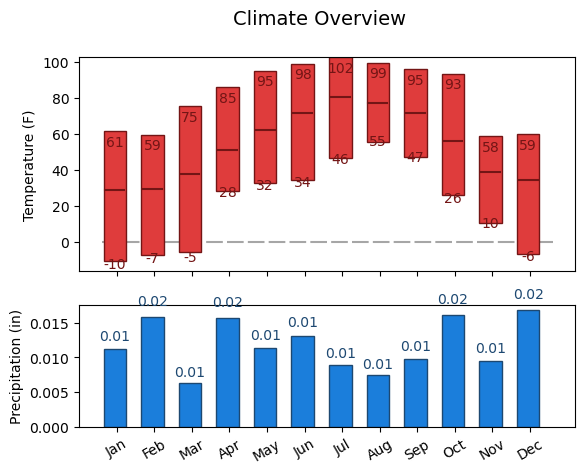

In [41]:
climate = climate_map('avgs.csv')

# plt.show()

# Fogless Mansion: 
### After becoming rich from your startup, you are looking for the perfect location to build your Bay Area mansion with unobstructed views. Find the locations that are the least foggy and show them on a map.

My first step to solve this problem was to import all of the plotting libraries from matplotlib and pandas. I then renamed the columns for latitude and longitude so that I wouldn't get errors from having ints in the column names when referencing them. I found the general latitude and longitude box for the bay area and started filtering the dataset with those values. 

I chose to have the ```visibility_surface``` of the point be higher than 24000m for the best visibility possible, and I found about 4400 points that way. Sadly, this set of results was not very good and when plotted gave really weird results with arcing lines of high visibility, so I scrapped it and adjusted my filter parameters.

My second test added a few more files from the summer of 2016 when the fog levels would be highest between June and August rather than just July in the first time around.

In [42]:
df = df.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")

In [43]:
df.take(1)

[Row(time=1444446000000, lat=37.03410173798036, lon=-86.05695551596708, albedo_surface=17.5, precipitable_water_entire_atmosphere_single_layer='null', pressure_maximum_wind=24327.35, pressure_surface=99510.0, pressure_tropopause=17589.562, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=289.48364, temperature_tropopause=215.17892, total_cloud_cover_entire_atmosphere_single_layer='null', total_precipitation_surface_3_hour_accumulation=3.125, vegetation_surface=68.5, visibility_surface=6225.0986, wilting_point_surface=0.083749995, wind_speed_gust_surface='null', _c18=None)]

In [44]:
df.createOrReplaceTempView("df")

clear = spark.sql('SELECT lat, lon, visibility_surface FROM df WHERE visibility_surface > 24000 \
                    AND 38 > lat AND lat > 37 AND 122 > lon AND 120 > 37')

In [45]:
clear.count()

4412

In [46]:
clear = clear.sort("lon")

In [47]:
clear.take(10)

[Row(lat=37.926845356438605, lon=-142.90356453629752, visibility_surface=24225.098),
 Row(lat=37.96375520843619, lon=-142.77647761022243, visibility_surface=24225.098),
 Row(lat=37.12373194475133, lon=-140.53346745813053, visibility_surface=24225.098),
 Row(lat=37.02253015513931, lon=-140.48921270521393, visibility_surface=24225.098),
 Row(lat=37.15900060943743, lon=-140.406534663633, visibility_surface=24225.098),
 Row(lat=37.057779911774986, lon=-140.3623842453857, visibility_surface=24225.098),
 Row(lat=37.194170274520346, lon=-140.27951654798267, visibility_surface=24225.098),
 Row(lat=37.092930747775085, lon=-140.23547068930893, visibility_surface=24225.098),
 Row(lat=37.33044439577855, lon=-140.19644147133275, visibility_surface=24225.098),
 Row(lat=37.22923946441522, lon=-140.15241834071287, visibility_surface=24225.098)]

<Axes: xlabel='lon', ylabel='lat'>

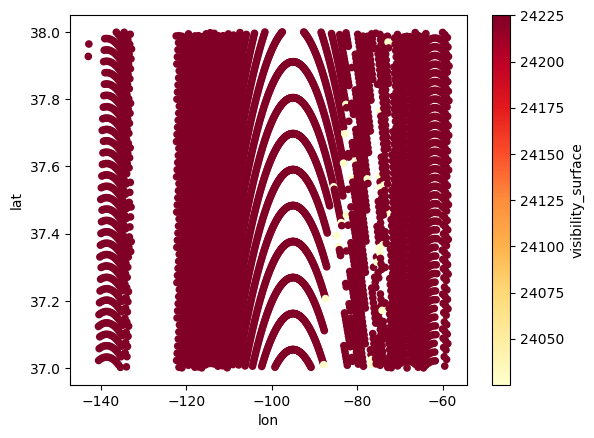

In [48]:
clear_df = clear.toPandas()

clear_df.plot(x="lon", y="lat", kind="scatter", c="visibility_surface",
        colormap="YlOrRd")

In [49]:
summer = spark.read.load('hdfs://orion01:25001/namanl_218_20160*0600*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [50]:
summer = summer.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")

summer.createOrReplaceTempView("summer")

summ = spark.sql('SELECT lat, lon, visibility_surface FROM summer WHERE 24000 > visibility_surface \
                    AND visibility_surface > 19000 AND 40 > lat AND lat > 36 AND -120 > lon AND lon > -125')

In [51]:
summ.count()

361

In [52]:
summ_df = summ.toPandas()

In [53]:
summ_df = summ_df.sort_values(by='lon', ascending=True)

summ_df.head()

,lat,lon,visibility_surface
339,39.503270,-124.993954,21021.096
25,39.503270,-124.993954,19823.299
205,36.002690,-124.968331,22620.227
107,36.888416,-124.941869,19224.170
7,37.225654,-124.899019,22223.299


In [54]:
summ.take(10)

[Row(lat=39.744509538378864, lon=-124.21776438733541, visibility_surface=21623.299),
 Row(lat=36.8704659890446, lon=-123.15289889292733, visibility_surface=19623.299),
 Row(lat=37.86296023200906, lon=-121.7591254916572, visibility_surface=23223.299),
 Row(lat=38.349399778106466, lon=-124.10543072501076, visibility_surface=22423.299),
 Row(lat=38.46699875651413, lon=-122.74668333839561, visibility_surface=21023.299),
 Row(lat=39.44608718482828, lon=-124.69577106854281, visibility_surface=22223.299),
 Row(lat=38.44528981948704, lon=-122.87991226817418, visibility_surface=20823.299),
 Row(lat=37.22565448795568, lon=-124.89901945989624, visibility_surface=22223.299),
 Row(lat=37.46435426679149, lon=-121.52116012335807, visibility_surface=20423.299),
 Row(lat=36.47603967223248, lon=-121.5495437336548, visibility_surface=23023.299)]

<Axes: xlabel='lon', ylabel='lat'>

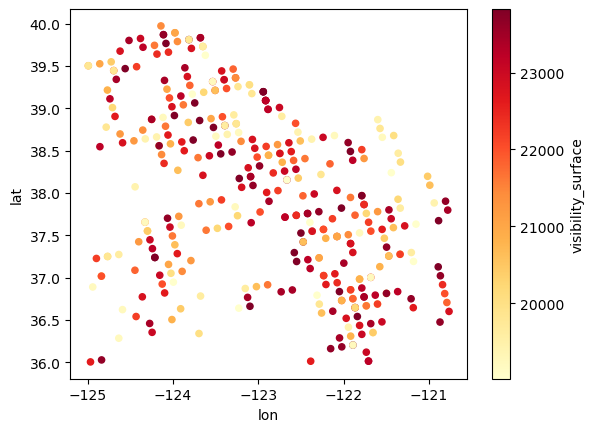

In [55]:
summ_df.plot(x="lon", y="lat", kind="scatter", c="visibility_surface",
        colormap="YlOrRd")

/tmp/ipykernel_397617/3653474827.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


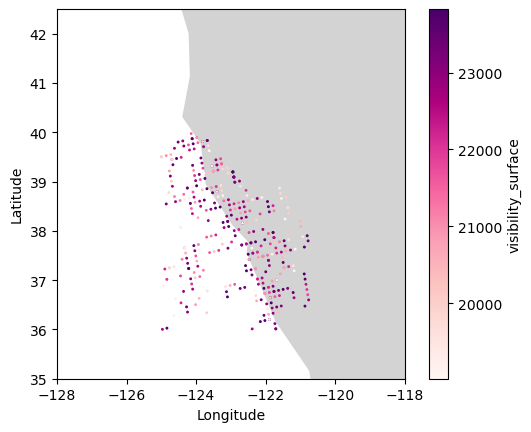

In [57]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

x = summ_df['lon']
y = summ_df['lat']
z = summ_df['visibility_surface']

plt.scatter(x, y, s=z/20000, c=z, cmap='RdPu')

plt.colorbar(label='visibility_surface')

plt.xlim([-128, -118])
plt.ylim([35, 42.5])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# SolarWind, Inc.: 
### After getting rich from your travel startup you get bored and start a new company; here, you want to help power companies plan out the locations of solar and wind farms across North America. Locate the top 3 places for solar and wind farms, as well as a combination of both (solar + wind farm). You will report a total of 9 Geohashes as well as their relevant attributes (for example, cloud cover and wind speeds).

For this problem, I stored all the files at 12pm for the entire 2019 data folder because there are valid `wind_speed_gust_surface` and `total_cloud_cover_entire_atmosphere_single_layer` values for 2019. I had to abandon my favorite 2016 dataset :'(

The next thing I did was try a few different ranges of wind gust speeds to filter on in North America, but ultimately decided on 50-70mph so that it was still a somewhat common speed. Some geohashes that were the best for wind farms based on these critera are *9wm6619rmzpp* (69.85mph), *9vqengzgyf40* (69.91mph), and *9xhukcmqdyt8* (69.87mph), all of which were not in the middle of the ocean (because that was a susprisingly annoying problem I kept running into).

I followed the same steps for cloud coverage (low cloud coverage means high sun exposure for solar panels) and eventually settled on a cloud coverage range of 0-15%. This was a bit harder to settle on because of duplicate points from all the files, but to fix that I aggreggated the average cloud coverage of all the points by geohash, this way I was sure that there was only one entry per location, and it could give a baseline estimate for yearly sun exposure. Three geohashes with low cloud coverage that could have solar energy farms are *djv29jbe3xt4* (0%), *dryzdfv0h5ke* (0%), and *9qn4n86pqg6g* (0%).

To find locations where combo wind and solar farms could be built, I combined both of the matching criteria for wind and solar farms into one dataset from 2019. From here i found another 3 geohashes that would be suitable: *9xmfjt08b78u* (50.03mph wind, 0% cloud cover), *9xqjvg1hwpmu* (50.03mph, 0%), and *9wht5bzj7k0v* (50.04mph, 0%).

In [58]:
df = spark.read.load('hdfs://orion01:25001/2019/namanl_218_2019*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

df = df.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
df = df.withColumn("geohash", geohashEncodeUDF(df.lat, df.lon))

In [59]:
# df = df.withColumn("wind_speed", df.pressure_maximum_wind * 0.00256) # convert wind pressure to wind speed (mph)
df = df.withColumn("wind_speed_gust_surface", df.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

In [60]:
# df = df.sort("total_cloud_cover_entire_atmosphere_single_layer")

# df = df.sort("albedo_surface")

df.take(1)

[Row(time=1554908400000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=2.476626, pressure_maximum_wind=30110.812, pressure_surface=103734.39, pressure_tropopause=26750.041, relative_humidity_zerodegc_isotherm=85.0, snow_depth_surface=0.05, temperature_surface=265.12515, temperature_tropopause=212.71329, total_cloud_cover_entire_atmosphere_single_layer=15.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=3.176638900162, _c18=None, geohash='f43k6gf3cc1q')]

In [61]:
df.createOrReplaceTempView("farms")

# wind.count()

In [62]:
wind = spark.sql('SELECT * FROM farms WHERE 70 > wind_speed_gust_surface AND wind_speed_gust_surface > 50 \
AND 24 < lat AND lat < 50 AND -66 > lon AND lon > -124')

In [63]:
wind.count()

123833

In [64]:
hashes = wind.groupBy("geohash")\
            .agg(F.avg("wind_speed_gust_surface").alias("wind_speed"), \
                F.avg("lat").alias("lat"), F.avg("lon").alias("lon"))

# 

In [65]:
wind_df = hashes.toPandas()

In [66]:
wind_df.count()

geohash       41975
wind_speed    41975
lat           41975
lon           41975
dtype: int64

/tmp/ipykernel_397617/2266684143.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


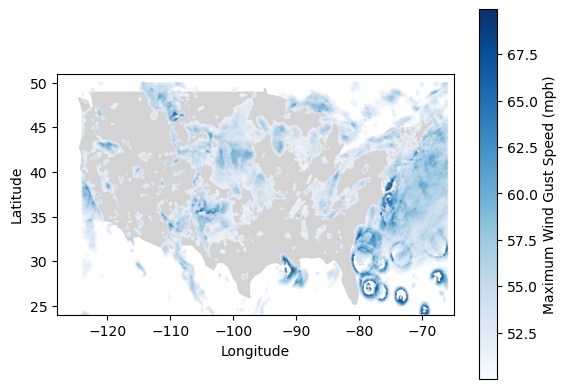

In [67]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = wind_df['lon']
y = wind_df['lat']
z = wind_df['wind_speed']
plt.scatter(x, y, s=z/1000, c=z, cmap='Blues')

plt.colorbar(label='Maximum Wind Gust Speed (mph)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [68]:
sun = spark.sql('SELECT * FROM farms WHERE total_cloud_cover_entire_atmosphere_single_layer < 15 AND \
        24 < lat AND lat < 50 AND -66 > lon AND lon > -124')

sun = sun.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
sun = sun.withColumn("geohash", geohashEncodeUDF(df.lat, df.lon))

sun.count()
# 60 < albedo_surface AND \

16162739

In [69]:
hashes = sun.groupBy("geohash").agg(\
                                    F.avg("total_cloud_cover_entire_atmosphere_single_layer").alias("cloud_cover"), \
                                    F.avg("lat").alias("lat"), F.avg("lon").alias("lon"))

hashes.limit(5).show()

+------------+------------------+------------------+-------------------+
|     geohash|       cloud_cover|               lat|                lon|
+------------+------------------+------------------+-------------------+
|c28myh173t6k| 3.292134831460674| 48.84580170664439|-123.13298143485787|
|9tcmrj5r8vey|1.2529644268774704| 33.29538550731319|-110.43006966847543|
|9uqzp170bk30| 1.900763358778626|25.143736797934785|  -91.4460631121707|
|cb1efpwsny9m| 1.338235294117647|45.701100808358575| -99.04351652302756|
|9xgvqjyzu854| 1.923913043478261| 44.54951801305214|-106.95342367875219|
+------------+------------------+------------------+-------------------+



In [70]:
sun_df = hashes.toPandas()

sun_df.count()

geohash        105672
cloud_cover    105672
lat            105672
lon            105672
dtype: int64

/tmp/ipykernel_397617/205822461.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


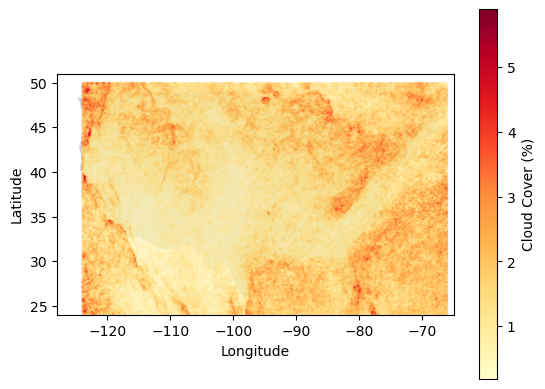

In [71]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = sun_df['lon']
y = sun_df['lat']
z = sun_df['cloud_cover']
plt.scatter(x, y, s=z/25, c=z, cmap='YlOrRd')

plt.colorbar(label='Cloud Cover (%)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [72]:
farms = spark.sql('SELECT * FROM farms WHERE total_cloud_cover_entire_atmosphere_single_layer < 15 AND \
        70 > wind_speed_gust_surface AND wind_speed_gust_surface > 50 AND \
        24 < lat AND lat < 50 AND -66 > lon AND lon > -124')

farms = farms.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
farms = farms.withColumn("geohash", geohashEncodeUDF(farms.lat, farms.lon))

In [73]:
farms.count()

14789

In [74]:
farms_df = farms.toPandas()

/tmp/ipykernel_397617/3153297965.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


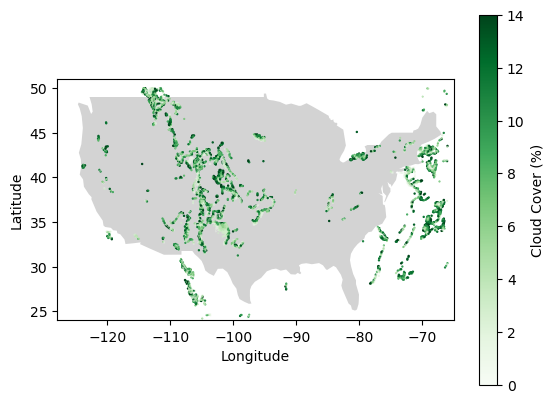

In [75]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = farms_df['lon']
y = farms_df['lat']
z = farms_df['total_cloud_cover_entire_atmosphere_single_layer']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z/25, c=z, cmap='Greens')

plt.colorbar(label='Cloud Cover (%)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

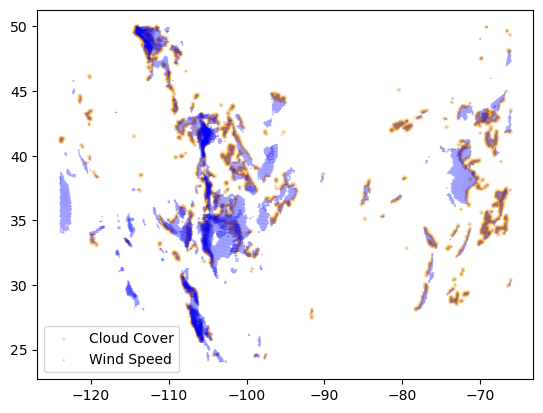

In [76]:
fig, ax = plt.subplots()

ax.scatter(farms_df.lon, farms_df.lat, c="Orange", \
           s=farms_df.total_cloud_cover_entire_atmosphere_single_layer, label="Cloud Cover", \
           alpha=0.3, edgecolors='none')

ax.scatter(farms_df.lon, farms_df.lat, c="Blue", \
           s=farms_df.wind_speed_gust_surface/40, label="Wind Speed", \
           alpha=0.3, edgecolors='none')

ax.legend()

plt.show()

In [77]:
wind.createOrReplaceTempView("wind")
sun.createOrReplaceTempView("sun")

In [78]:
wind = wind.sort(desc("wind_speed_gust_surface"))

In [79]:
wind.take(50)

[Row(time=1547499600000, lat=38.91414277524665, lon=-66.7476671082689, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=26.3, pressure_maximum_wind=16678.62, pressure_surface=99605.11, pressure_tropopause=27510.537, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=292.29138, temperature_tropopause=221.4313, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=37.0, vegetation_surface=0.0, visibility_surface=3100.0, wilting_point_surface=0.0, wind_speed_gust_surface=69.98532985860001, _c18=None, geohash='dwbt3h5g69up'),
 Row(time=1547499600000, lat=39.49272406977406, lon=-66.30842436025102, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=25.4, pressure_maximum_wind=17169.02, pressure_surface=99842.71, pressure_tropopause=26633.738, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=291.29138, temperature_tropopause=216.9313

In [80]:
sun = sun.sort("total_cloud_cover_entire_atmosphere_single_layer")

In [81]:
sun.take(50)

[Row(time=1546635600000, lat=36.205808044268565, lon=-103.0840330782546, albedo_surface=34.3, precipitable_water_entire_atmosphere_single_layer=7.7, pressure_maximum_wind=16152.447, pressure_surface=85781.42, pressure_tropopause=24890.246, relative_humidity_zerodegc_isotherm=33.0, snow_depth_surface=0.03104, temperature_surface=280.084, temperature_tropopause=221.69604, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=20.4, visibility_surface=24100.0, wilting_point_surface=0.023, wind_speed_gust_surface=4.251349432494, _c18=None, geohash='9wqtyr06pgvc'),
 Row(time=1546635600000, lat=24.940258677131066, lon=-112.41715713150089, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=13.4, pressure_maximum_wind=19978.047, pressure_surface=101414.23, pressure_tropopause=11631.047, relative_humidity_zerodegc_isotherm=37.0, snow_depth_surface=0.0, temperature_surface=293.51404, temperature_tropopause=

In [82]:
farms = farms.sort("total_cloud_cover_entire_atmosphere_single_layer", "wind_speed_gust_surface")

In [83]:
farms.take(50)

[Row(time=1571410800000, lat=39.487788596777335, lon=-96.60116871180765, albedo_surface=18.3, precipitable_water_entire_atmosphere_single_layer=13.854528, pressure_maximum_wind=30147.387, pressure_surface=95826.03, pressure_tropopause=11716.075, relative_humidity_zerodegc_isotherm=9.0, snow_depth_surface=0.0, temperature_surface=287.06793, temperature_tropopause=204.39998, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=34.0, visibility_surface=24100.0, wilting_point_surface=0.12, wind_speed_gust_surface=50.0032481501, _c18=None, geohash='9z529u91j97f'),
 Row(time=1571410800000, lat=40.115096699480944, lon=-97.30176770246692, albedo_surface=18.3, precipitable_water_entire_atmosphere_single_layer=14.954529, pressure_maximum_wind=30285.787, pressure_surface=94927.63, pressure_tropopause=11226.475, relative_humidity_zerodegc_isotherm=8.0, snow_depth_surface=0.0, temperature_surface=287.16794, temperature_tropopa

# Climate Change:
### Using two-character geohash aggregates across the entire NAM grid, determine temperature trends over the past 5 years. With the regions that have experienced an increase in temperatures, build a correlation matrix using Pearson’s correlation coefficient (PCC) to determine how the variables influence one another. Finally, determine whether or not the correlations are different based on the region (e.g., maybe temperature has increased in lockstep with humidity in one location but not another). Analyze your results: can you draw any conclusions from what you’ve found?


The first thing I did was download data from everyday in 2015-2019 at 12pm and made one dataframe per year. Like the other problems, I also renamed the lat and lon columns, and added a geohash column to each of the dataframes, but this time the geohash was only 2 characters so that aggreggation would be easier.

My next step was to aggregate the values in each dataframe by geohash, add a column for the year (for easy year differentiation in the next step), and add a bunch of the original columns to the aggregate dataframes (including humidity, cloud cover, vegetation, etc.). I then plotted each of the yearly aggregate dataframes and tried to look for differences in colors. Spoiler alert!! That didn't go well :')

After that didn't work, I appended all of the agg dataframes into one dataframe and then went through all 77 geohashes in the grid, with a threshold of 5 degrees Fahrenheit to be considered a significant increase in temperature. I found 27 hashes that fulfilled this criteria (they are all listed below as comments a bit further down in the notebook), all of which were between 2016 and 2017. The majority of the hashes were west of Kansas, as well as the Canadian wilderness.

Next I created a correlation matrix for a few of the geohashes that were in the same bounding box (f, c, and 9) to see if there were any trends with the matrices. For the majority of the matrices 9 and c geohashes (the western US and a bit of western Canada), there was a strong inverse relationship between the temperature, humidity, and cloud cover. The low cloud cover and humidity at the time made me think that there was very little moisture in the air in 2017, so there may have been a drought at the time. My guess was proven correct by a little bit of internet searching that confirmed a Northern American drought that was reaching its tail end in 2017!

For the eastern Canadian region (f), the biggest correlation was the inverse relationship between snowfall and the temperature of the region. The conclusion I came to was that Northeastern Canada was going through a period of low snowfall in 2017 that was a side effect of the droughts hapening in other places in North America. The lack of moisture in the air that could eventually become snow was most likely the cause of the warmer temperatures that year.



In [84]:
df_2019 = spark.read.load('hdfs://orion01:25001/2019/namanl_218_2019*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [85]:
df_2019 = df_2019.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
df_2019.count()

98284208

In [86]:
df_2019 = df_2019.withColumn("geohash", geohash2Encode(df_2019.lat, df_2019.lon))
df_2019 = df_2019.withColumn("temperature_surface", k2f(df_2019.temperature_surface))
df_2019 = df_2019.withColumn("wind_speed_gust_surface", df_2019.wind_speed_gust_surface * 2.23694)

In [87]:
df_2019.take(1)

[Row(time=1554908400000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=2.476626, pressure_maximum_wind=30110.812, pressure_surface=103734.39, pressure_tropopause=26750.041, relative_humidity_zerodegc_isotherm=85.0, snow_depth_surface=0.05, temperature_surface=17.555270000000007, temperature_tropopause=212.71329, total_cloud_cover_entire_atmosphere_single_layer=15.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=3.176638900162, _c18=None, geohash='f4')]

In [88]:
agg_2019 = df_2019.groupBy("geohash")\
                .agg(\
                    F.avg("lat").alias("lat"), \
                    F.avg("lon").alias("lon"), \
                    F.avg("visibility_surface").alias("visibility_surface"), \
                    F.avg("snow_depth_surface").alias("snow_depth_surface"), \
                    F.avg("total_precipitation_surface_3_hour_accumulation").alias("total_rain"), \
                    F.avg("total_cloud_cover_entire_atmosphere_single_layer").alias("cloud_cover"), \
                    F.avg("relative_humidity_zerodegc_isotherm").alias("humidity"), \
                    F.avg("vegetation_surface").alias("vegetation_surface"), \
                    F.avg("wind_speed_gust_surface").alias("wind_speed"), \
                    F.avg("temperature_surface").alias("temperature"))

In [89]:
agg_2019.take(1)

[Row(geohash='f2', lat=47.8056014853745, lon=-73.12548467966232, visibility_surface=20758.37688164881, snow_depth_surface=0.1095837879993148, total_rain=0.338304716095432, cloud_cover=55.16759599342811, humidity=66.72361378067889, vegetation_surface=36.52830583414271, wind_speed=16.879887128496254, temperature=43.76398660370335)]

In [90]:
agg_2019.count()

77

In [91]:
agg_2019_df = agg_2019.toPandas()

In [92]:
agg_2019_df.count()

geohash               77
lat                   77
lon                   77
visibility_surface    77
snow_depth_surface    77
total_rain            77
cloud_cover           77
humidity              77
vegetation_surface    77
wind_speed            77
temperature           77
dtype: int64

In [93]:
agg_2019_df['year'] = 2019

/tmp/ipykernel_397617/21683467.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


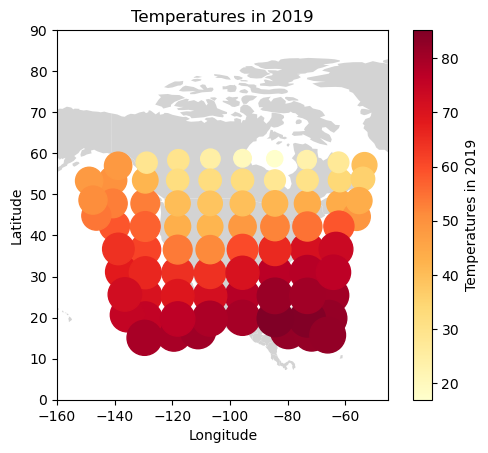

In [94]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["continent"] == "North America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = agg_2019_df['lon']
y = agg_2019_df['lat']
z = agg_2019_df['temperature']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z*8, c=z, cmap='YlOrRd')

plt.colorbar(label='Temperatures in 2019')

plt.xlim([-160, -45])
plt.ylim([0, 90])

plt.title("Temperatures in 2019")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [95]:
df_2018 = spark.read.load('hdfs://orion01:25001/2018/namanl_218_2018*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
df_2018 = df_2018.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
# df_2018.count()

In [97]:
df_2018 = df_2018.withColumn("geohash", geohash2Encode(df_2018.lat, df_2018.lon))
df_2018 = df_2018.withColumn("temperature_surface", k2f(df_2018.temperature_surface))
df_2018 = df_2018.withColumn("wind_speed_gust_surface", df_2018.wind_speed_gust_surface * 2.23694)

In [98]:
# df_2018.take(1)

[Row(time=1542985200000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=9.621094, pressure_maximum_wind=29142.781, pressure_surface=99825.19, pressure_tropopause=24309.664, relative_humidity_zerodegc_isotherm=89.0, snow_depth_surface=0.04076, temperature_surface=21.73189999999994, temperature_tropopause=212.88919, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=0.125, vegetation_surface=0.0, visibility_surface=20600.0, wilting_point_surface=0.0, wind_speed_gust_surface=5.838475586932001, _c18=None, geohash='f4')]

In [99]:
agg_2018 = df_2018.groupBy("geohash")\
                .agg(\
                    F.avg("lat").alias("lat"), \
                    F.avg("lon").alias("lon"), \
                    F.avg("visibility_surface").alias("visibility_surface"), \
                    F.avg("snow_depth_surface").alias("snow_depth_surface"), \
                    F.avg("total_precipitation_surface_3_hour_accumulation").alias("total_rain"), \
                    F.avg("total_cloud_cover_entire_atmosphere_single_layer").alias("cloud_cover"), \
                    F.avg("relative_humidity_zerodegc_isotherm").alias("humidity"), \
                    F.avg("vegetation_surface").alias("vegetation_surface"), \
                    F.avg("wind_speed_gust_surface").alias("wind_speed"), \
                    F.avg("temperature_surface").alias("temperature"))

In [3]:
# agg_2018.take(1)

In [4]:
# agg_2018.count()

In [102]:
agg_2018_df = agg_2018.toPandas()

In [103]:
agg_2018_df['year'] = 2018

In [104]:
agg_2018_df.count()

geohash               77
lat                   77
lon                   77
visibility_surface    77
snow_depth_surface    77
total_rain            77
cloud_cover           77
humidity              77
vegetation_surface    77
wind_speed            77
temperature           77
year                  77
dtype: int64

/tmp/ipykernel_397617/3672918771.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


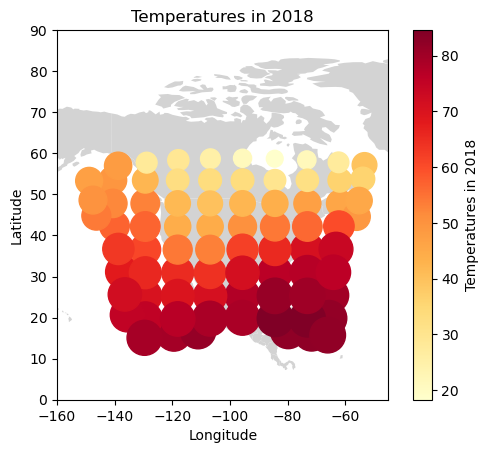

In [105]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["continent"] == "North America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = agg_2018_df['lon']
y = agg_2018_df['lat']
z = agg_2018_df['temperature']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z*8, c=z, cmap='YlOrRd')

plt.colorbar(label='Temperatures in 2018')

plt.xlim([-160, -45])
plt.ylim([0, 90])

plt.title("Temperatures in 2018")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [106]:
df_2017 = spark.read.load('hdfs://orion01:25001/2017/namanl_218_2017*.tdv',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
df_2017 = df_2017.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
# df_2017.count()

In [108]:
df_2017 = df_2017.withColumn("geohash", geohash2Encode(df_2017.lat, df_2017.lon))
df_2017 = df_2017.withColumn("temperature_surface", k2f(df_2017.temperature_surface))
df_2017 = df_2017.withColumn("wind_speed_gust_surface", df_2017.wind_speed_gust_surface * 2.23694)

In [109]:
# df_2017.take(1)

In [110]:
agg_2017 = df_2017.groupBy("geohash")\
                .agg(\
                    F.avg("lat").alias("lat"), \
                    F.avg("lon").alias("lon"), \
                    F.avg("visibility_surface").alias("visibility_surface"), \
                    F.avg("snow_depth_surface").alias("snow_depth_surface"), \
                    F.avg("total_precipitation_surface_3_hour_accumulation").alias("total_rain"), \
                    F.avg("total_cloud_cover_entire_atmosphere_single_layer").alias("cloud_cover"), \
                    F.avg("relative_humidity_zerodegc_isotherm").alias("humidity"), \
                    F.avg("vegetation_surface").alias("vegetation_surface"), \
                    F.avg("wind_speed_gust_surface").alias("wind_speed"), \
                    F.avg("temperature_surface").alias("temperature"))

In [111]:
# agg_2017.take(1)

In [112]:
agg_2017_df = agg_2017.toPandas()

In [113]:
agg_2017_df['year'] = 2017

In [114]:
# agg_2017_df.count()

/tmp/ipykernel_397617/2538951546.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


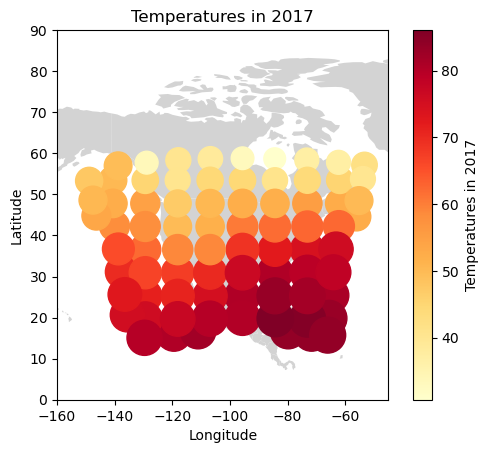

In [115]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["continent"] == "North America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = agg_2017_df['lon']
y = agg_2017_df['lat']
z = agg_2017_df['temperature']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z*8, c=z, cmap='YlOrRd')

plt.colorbar(label='Temperatures in 2017')

plt.xlim([-160, -45])
plt.ylim([0, 90])

plt.title("Temperatures in 2017")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [116]:
df_2016 = spark.read.load('hdfs://orion01:25001/2016/namanl_218_2016*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [117]:
df_2016 = df_2016.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
df_2016.count()

84093440

In [118]:
df_2016 = df_2016.withColumn("geohash", geohash2Encode(df_2016.lat, df_2016.lon))
df_2016 = df_2016.withColumn("temperature_surface", k2f(df_2016.temperature_surface))
df_2016 = df_2016.withColumn("wind_speed_gust_surface", df_2016.wind_speed_gust_surface * 2.23694)

In [119]:
# df_2016.take(1)

In [120]:
agg_2016 = df_2016.groupBy("geohash")\
                .agg(\
                    F.avg("lat").alias("lat"), \
                    F.avg("lon").alias("lon"), \
                    F.avg("visibility_surface").alias("visibility_surface"), \
                    F.avg("snow_depth_surface").alias("snow_depth_surface"), \
                    F.avg("total_precipitation_surface_3_hour_accumulation").alias("total_rain"), \
                    F.avg("relative_humidity_zerodegc_isotherm").alias("humidity"), \
                    F.avg("vegetation_surface").alias("vegetation_surface"), \
                    F.avg("temperature_surface").alias("temperature"))

In [121]:
# agg_2016.take(1)

In [122]:
# agg_2016.count()

In [123]:
agg_2016_df = agg_2016.toPandas()

In [124]:
agg_2016_df['year'] = 2016

In [125]:
agg_2016_df.count()

geohash               77
lat                   77
lon                   77
visibility_surface    77
snow_depth_surface    77
total_rain            77
humidity              77
vegetation_surface    77
temperature           77
year                  77
dtype: int64

/tmp/ipykernel_397617/3470856613.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


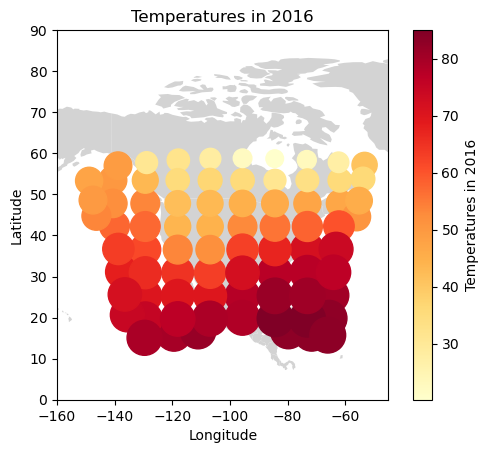

In [126]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["continent"] == "North America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = agg_2016_df['lon']
y = agg_2016_df['lat']
z = agg_2016_df['temperature']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z*8, c=z, cmap='YlOrRd')

plt.colorbar(label='Temperatures in 2016')

plt.xlim([-160, -45])
plt.ylim([0, 90])

plt.title("Temperatures in 2016")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [127]:
df_2015 = spark.read.load('hdfs://orion01:25001/2015/namanl_218_2015*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [128]:
df_2015 = df_2015.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
df_2015.count()

80414352

In [129]:
df_2015 = df_2015.withColumn("geohash", geohash2Encode(df_2015.lat, df_2015.lon))
df_2015 = df_2015.withColumn("temperature_surface", k2f(df_2015.temperature_surface))
df_2015 = df_2015.withColumn("wind_speed_gust_surface", df_2015.wind_speed_gust_surface * 2.23694)

In [130]:
# df_2016.take(1)

In [131]:
agg_2015 = df_2015.groupBy("geohash")\
                .agg(\
                    F.avg("lat").alias("lat"), \
                    F.avg("lon").alias("lon"), \
                    F.avg("visibility_surface").alias("visibility_surface"), \
                    F.avg("snow_depth_surface").alias("snow_depth_surface"), \
                    F.avg("total_precipitation_surface_3_hour_accumulation").alias("total_rain"), \
                    F.avg("relative_humidity_zerodegc_isotherm").alias("humidity"), \
                    F.avg("vegetation_surface").alias("vegetation_surface"), \
                    F.avg("temperature_surface").alias("temperature"))

In [132]:
# agg_2015.take(1)

In [133]:
# agg_2015.count()

In [134]:
agg_2015_df = agg_2015.toPandas()

In [135]:
agg_2015_df['year'] = 2015

In [136]:
agg_2015_df.count()

geohash               77
lat                   77
lon                   77
visibility_surface    77
snow_depth_surface    77
total_rain            77
humidity              77
vegetation_surface    77
temperature           77
year                  77
dtype: int64

/tmp/ipykernel_397617/2959523338.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


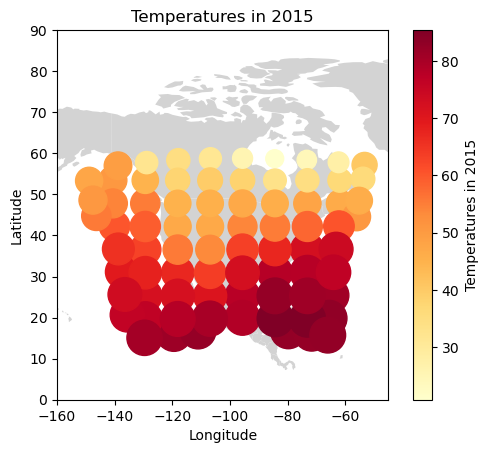

In [137]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["continent"] == "North America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = agg_2015_df['lon']
y = agg_2015_df['lat']
z = agg_2015_df['temperature']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z*8, c=z, cmap='YlOrRd')

plt.colorbar(label='Temperatures in 2015')

plt.xlim([-160, -45])
plt.ylim([0, 90])

plt.title("Temperatures in 2015")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [138]:
five_years = pd.DataFrame()

In [139]:
five_years = five_years.append(agg_2015_df)\
                        .append(agg_2016_df).append(agg_2017_df).append(agg_2018_df)\
                        .append(agg_2019_df)

/tmp/ipykernel_397617/1534281783.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_years = five_years.append(agg_2015_df)\
/tmp/ipykernel_397617/1534281783.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(agg_2016_df).append(agg_2017_df).append(agg_2018_df)\
/tmp/ipykernel_397617/1534281783.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(agg_2016_df).append(agg_2017_df).append(agg_2018_df)\
/tmp/ipykernel_397617/1534281783.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(agg_2019_df)


In [140]:
five_years.count()

geohash               385
lat                   385
lon                   385
visibility_surface    385
snow_depth_surface    385
total_rain            385
humidity              385
vegetation_surface    385
temperature           385
year                  385
cloud_cover           231
wind_speed            231
dtype: int64

In [141]:
five_years = five_years.sort_values(by=['geohash', 'year'])

In [142]:
five_years.iloc[370:] # threshold is >= 5F jumps in avg temp over a year

# 9q: 2016-2017 had a 5F jump in temp
# 9r: 2016-2017 had a 6F jump in temp
# 9s: 2016-2017 had a 5F jump in temp
# 9t: 2016-2017 had a 7F jump in temp
# 9w: 2016-2017 had a 7F jump in temp
# 9x: 2016-2017 had a 7F jump in temp
# 9y: 2016-2017 had a 7F jump in temp
# 9z: 2016-2017 had a 8F jump in temp
# c3: 2016-2017 had a 5F jump in temp
# c6: 2016-2017 had a 5F jump in temp
# c8: 2016-2017 had a 6F jump in temp
# c9: 2016-2017 had a 7F jump in temp
# cb: 2016-2017 had a 7F jump in temp
# cc: 2016-2017 had a 9F jump in temp
# cd: 2016-2017 had a 10F jump in temp
# cf: 2016-2017 had a 11F jump in temp
# dn: 2016-2017 had a 5F jump in temp
# dp: 2016-2017 had a 6F jump in temp
# f0: 2016-2017 had a 6F jump in temp
# f1: 2016-2017 had a 10F jump in temp
# f2: 2016-2017 had a 8F jump in temp
# f3: 2016-2017 had a 10F jump in temp
# f4: 2016-2017 had a 10F jump in temp
# f6: 2016-2017 had a 14F jump in temp
# f8: 2016-2017 had a 6F jump in temp
# f9: 2016-2017 had a 9F jump in temp
# fd: 2016-2017 had a 9F jump in temp

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
73,fc,53.753659,-53.819347,18342.141137,1.856562e-02,0.404217,78.737694,1.079014,36.085403,2015,NaN,NaN
73,fc,53.753659,-53.819347,18261.825498,1.904269e-02,0.384250,80.970832,1.013815,36.117720,2016,NaN,NaN
73,fc,53.752812,-53.852728,18527.418369,6.564820e-03,0.355396,74.107778,1.190457,40.169605,2017,71.466761,22.523103
73,fc,53.752812,-53.852728,18579.887141,1.271682e-02,0.407463,77.790976,0.892062,36.061854,2018,72.045815,25.745514
73,fc,53.752812,-53.852728,17642.955508,1.125088e-02,0.384523,80.328735,0.850722,35.799335,2019,76.776682,25.799396
60,fd,57.816947,-62.307671,18093.249015,1.877017e-01,0.297201,80.203973,4.535085,27.753688,2015,NaN,NaN
60,fd,57.816947,-62.307671,17899.710123,2.769573e-01,0.298654,80.744231,4.371291,27.325685,2016,NaN,NaN
60,fd,57.805610,-62.312357,19228.448211,4.833486e-02,0.267437,78.822340,5.752671,37.060550,2017,65.573156,19.333616
60,fd,57.805610,-62.312357,18991.567638,9.526849e-02,0.257092,79.406690,4.369786,27.538213,2018,63.098870,20.407781
60,fd,57.805610,-62.312357,17660.469963,8.530007e-02,0.281401,79.684685,4.237353,27.426171,2019,68.251833,20.289545


In [143]:
#Locations with drastic temperature increases between 2016-2017:

# 9q: 2016-2017 had a 5F jump in temp
# 9r: 2016-2017 had a 6F jump in temp
# 9s: 2016-2017 had a 5F jump in temp
# 9t: 2016-2017 had a 7F jump in temp
# 9w: 2016-2017 had a 7F jump in temp
# 9x: 2016-2017 had a 7F jump in temp
# 9y: 2016-2017 had a 7F jump in temp
# 9z: 2016-2017 had a 8F jump in temp
# c3: 2016-2017 had a 5F jump in temp
# c6: 2016-2017 had a 5F jump in temp
# c8: 2016-2017 had a 6F jump in temp
# c9: 2016-2017 had a 7F jump in temp
# cb: 2016-2017 had a 7F jump in temp
# cc: 2016-2017 had a 9F jump in temp
# cd: 2016-2017 had a 10F jump in temp
# cf: 2016-2017 had a 11F jump in temp
# dn: 2016-2017 had a 5F jump in temp
# dp: 2016-2017 had a 6F jump in temp
# f0: 2016-2017 had a 6F jump in temp
# f1: 2016-2017 had a 10F jump in temp
# f2: 2016-2017 had a 8F jump in temp
# f3: 2016-2017 had a 10F jump in temp
# f4: 2016-2017 had a 10F jump in temp
# f6: 2016-2017 had a 14F jump in temp
# f8: 2016-2017 had a 6F jump in temp
# f9: 2016-2017 had a 9F jump in temp
# fd: 2016-2017 had a 9F jump in temp

In [144]:
_9q = five_years.loc[five_years['geohash'] == '9q']

_9q.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
33,9q,36.550379,-118.123160,23182.682174,0.002150,0.089055,41.780937,16.946428,55.402402,2015,NaN,NaN
33,9q,36.550379,-118.123160,22792.078399,0.005639,0.137543,40.005545,16.913959,53.521112,2016,NaN,NaN
33,9q,36.548463,-118.125079,22674.741225,0.001783,0.053293,37.436368,17.256934,58.901671,2017,23.810372,10.552502
33,9q,36.548463,-118.125079,22343.760919,0.004107,0.104233,41.528984,16.997745,54.182108,2018,29.263870,10.482465
33,9q,36.548463,-118.125079,21879.528077,0.014021,0.177454,44.472573,16.848991,53.559477,2019,34.248900,11.419102


/tmp/ipykernel_397617/395476917.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9q.corr()


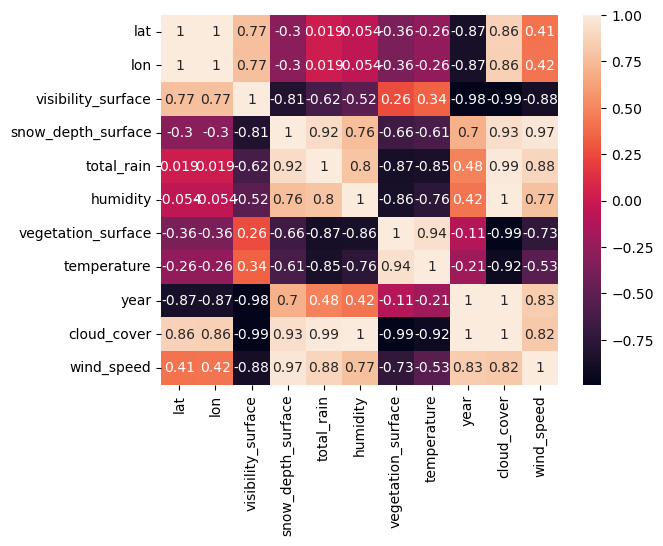

In [145]:
corr_matrix = _9q.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [146]:
_9r = five_years.loc[five_years['geohash'] == '9r']

_9r.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
11,9r,42.178005,-118.127113,22156.946988,0.011380,0.206027,59.894877,28.094954,46.859133,2015,NaN,NaN
11,9r,42.178005,-118.127113,21645.757046,0.022318,0.232243,61.275309,26.986348,43.742841,2016,NaN,NaN
11,9r,42.177672,-118.125690,22546.382733,0.009852,0.126462,56.987521,30.972061,49.776844,2017,28.169951,9.025291
11,9r,42.177672,-118.125690,21796.202967,0.014672,0.151861,60.263982,27.434025,44.341328,2018,33.451249,9.238068
11,9r,42.177672,-118.125690,21224.094046,0.035228,0.215044,63.647415,26.731160,43.226374,2019,39.551047,9.834508


/tmp/ipykernel_397617/1686112349.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9r.corr()


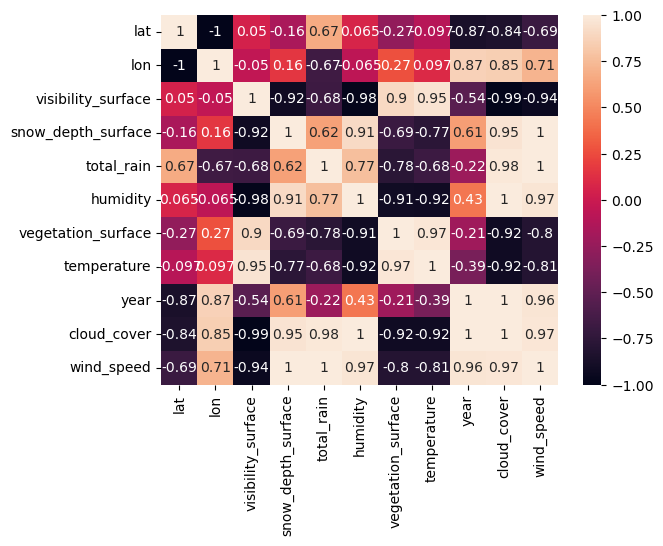

In [147]:
corr_matrix = _9r.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [148]:
_9s = five_years.loc[five_years['geohash'] == '9s']

_9s.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
29,9s,25.290656,-106.874191,23240.061748,0.000013,0.171259,45.270027,20.465235,70.970031,2015,NaN,NaN
29,9s,25.290656,-106.874191,23215.545591,0.000026,0.148302,39.981817,20.584102,69.844371,2016,NaN,NaN
29,9s,25.290516,-106.872107,22663.322085,0.000058,0.156796,41.049000,21.379695,75.115046,2017,23.246789,8.964558
29,9s,25.290516,-106.872107,22726.524720,0.000003,0.132475,41.267470,20.456232,71.059874,2018,23.257854,9.330259
29,9s,25.290516,-106.872107,22801.653346,0.000003,0.108598,38.464972,20.351936,71.619739,2019,25.841619,9.817526


/tmp/ipykernel_397617/4037066553.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9s.corr()


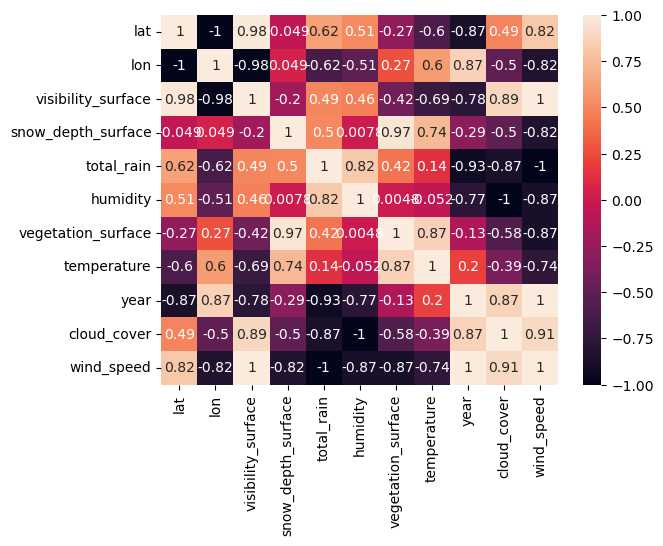

In [149]:
corr_matrix = _9s.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [150]:
_9t = five_years.loc[five_years['geohash'] == '9t']

_9t.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
59,9t,30.918842,-106.876762,23410.047048,0.000563,0.141772,47.087220,19.700713,63.873590,2015,NaN,NaN
59,9t,30.918842,-106.876762,23500.765828,0.000254,0.103013,42.176756,19.675752,63.055714,2016,NaN,NaN
58,9t,30.919963,-106.876250,23368.998449,0.000147,0.106634,40.921231,21.104759,70.188548,2017,17.400227,10.633771
58,9t,30.919963,-106.876250,23328.309522,0.000135,0.107536,41.531212,19.645498,64.241510,2018,22.021024,10.890186
58,9t,30.919963,-106.876250,23313.225628,0.000364,0.093372,42.756654,19.385603,64.155134,2019,23.625046,11.303960


/tmp/ipykernel_397617/2202809226.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9t.corr()


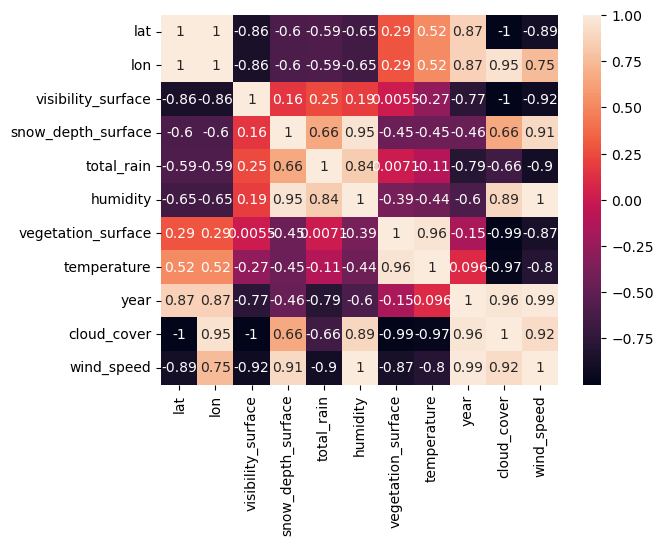

In [151]:
corr_matrix = _9t.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [152]:
_9w = five_years.loc[five_years['geohash'] == '9w']

_9w.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
76,9w,36.546152,-106.875880,22965.972232,0.010188,0.174150,58.721276,23.193403,53.346764,2015,NaN,NaN
76,9w,36.546152,-106.875880,23170.332392,0.012368,0.119010,55.860828,22.447078,51.947626,2016,NaN,NaN
76,9w,36.548142,-106.875401,23511.174645,0.003813,0.109005,50.251687,25.778796,58.936818,2017,19.509226,12.109408
76,9w,36.548142,-106.875401,23266.926946,0.006683,0.100318,53.281944,22.754468,53.222531,2018,22.838995,12.511752
76,9w,36.548142,-106.875401,22694.681718,0.019166,0.142938,57.801280,22.218023,51.437767,2019,27.984852,13.011712


/tmp/ipykernel_397617/4001752019.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9w.corr()


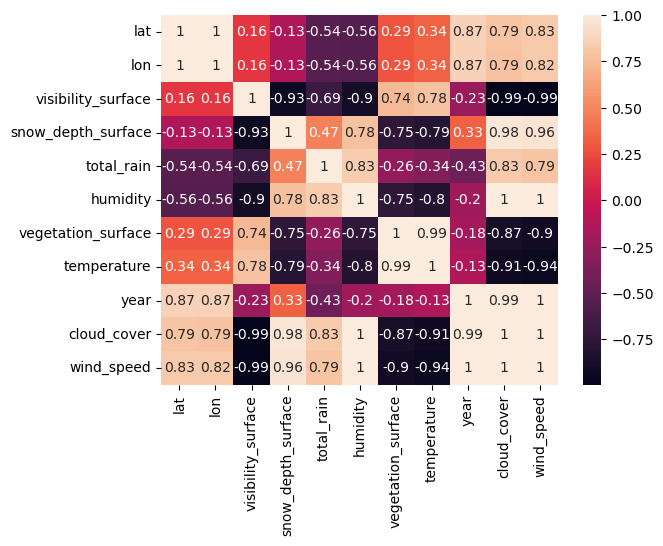

In [153]:
corr_matrix = _9w.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [154]:
_9x = five_years.loc[five_years['geohash'] == '9x']

_9x.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
10,9x,42.175562,-106.874999,22252.658725,0.032646,0.192251,64.803637,22.881070,46.843322,2015,NaN,NaN
10,9x,42.175562,-106.874999,22164.471845,0.051944,0.173727,64.601082,21.300352,44.540515,2016,NaN,NaN
10,9x,42.177537,-106.874244,22664.769423,0.022952,0.137809,60.743199,27.187355,51.886502,2017,27.630570,12.930701
10,9x,42.177537,-106.874244,21989.530688,0.033632,0.149251,63.789500,21.890981,44.434526,2018,33.586898,13.206536
10,9x,42.177537,-106.874244,21519.025035,0.057081,0.178081,67.044382,20.947522,41.980397,2019,37.813336,13.536380


/tmp/ipykernel_397617/1622083642.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = _9x.corr()


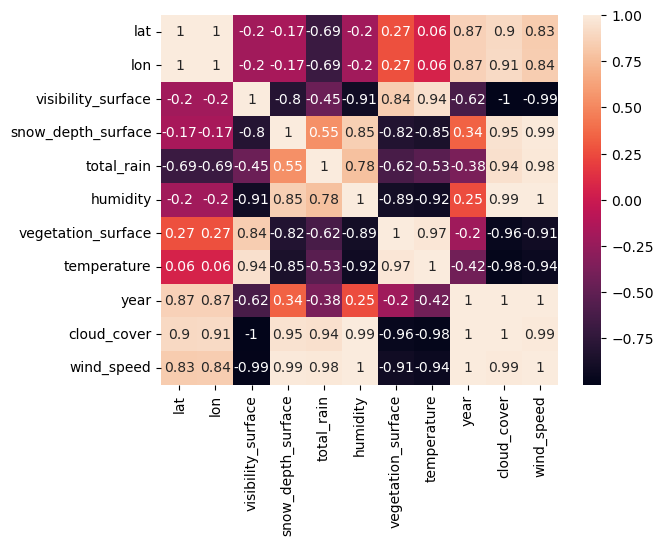

In [155]:
corr_matrix = _9x.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [156]:
c3 = five_years.loc[five_years['geohash'] == 'c3']

c3.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
53,c3,53.433635,-118.128456,20583.300544,0.120606,0.228301,76.015331,37.310475,37.803358,2015,NaN,NaN
53,c3,53.433635,-118.128456,20008.805223,0.128364,0.261363,79.164815,35.027699,35.179453,2016,NaN,NaN
53,c3,53.431798,-118.126636,20125.922881,0.057383,0.231251,72.778268,44.540953,40.443268,2017,49.080502,12.692368
53,c3,53.431798,-118.126636,19395.318939,0.115672,0.218839,76.133283,35.775956,32.708467,2018,49.730915,11.909678
53,c3,53.431798,-118.126636,19363.796830,0.119578,0.228670,77.579259,34.419891,32.004084,2019,52.756453,11.875971


/tmp/ipykernel_397617/1242098934.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = c3.corr()


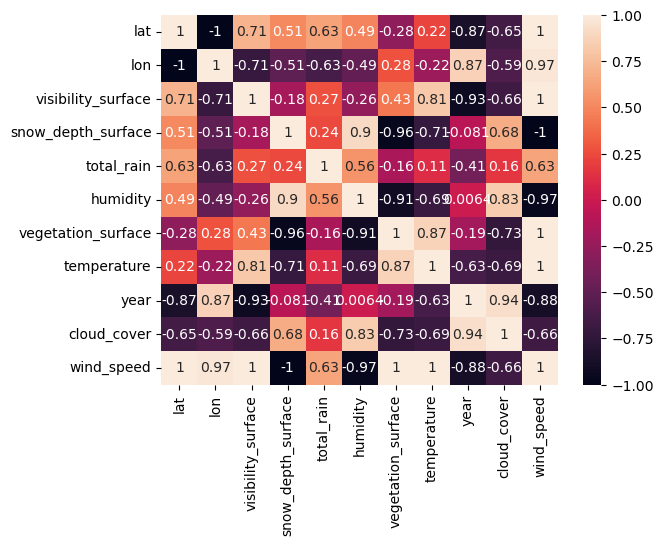

In [157]:
corr_matrix = c3.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [158]:
cf = five_years.loc[five_years['geohash'] == 'cf']

cf.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
42,cf,58.796534,-95.620226,20079.063931,0.150466,0.181166,76.689426,13.300586,25.832391,2015,NaN,NaN
42,cf,58.796534,-95.620226,19646.157871,0.197686,0.182848,78.503102,12.421658,22.403147,2016,NaN,NaN
41,cf,58.797982,-95.624255,19925.437790,0.074330,0.170181,74.948999,16.646484,33.216027,2017,52.126181,16.668413
41,cf,58.797982,-95.624255,20625.964133,0.120442,0.122040,75.975677,12.518040,21.204255,2018,47.622904,16.208810
41,cf,58.797982,-95.624255,19627.542462,0.127037,0.153763,76.426177,12.031733,20.018189,2019,52.188033,16.645629


/tmp/ipykernel_397617/1023865698.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = cf.corr()


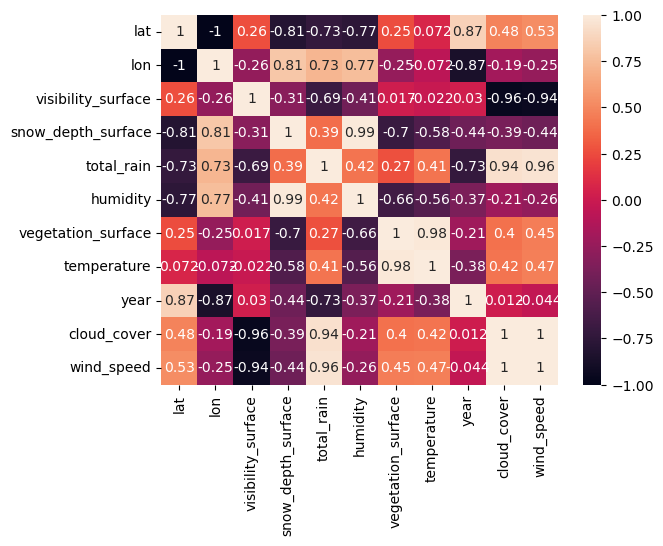

In [159]:
corr_matrix = cf.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [160]:
cd = five_years.loc[five_years['geohash'] == 'cd']

cd.head(5)

,geohash,lat,lon,visibility_surface,snow_depth_surface,total_rain,humidity,vegetation_surface,temperature,year,cloud_cover,wind_speed
21,cd,58.680946,-106.780076,20724.071753,0.147264,0.167163,76.147794,21.191878,31.481586,2015,NaN,NaN
21,cd,58.680946,-106.780076,19727.400666,0.194173,0.225094,78.837240,19.614679,28.082232,2016,NaN,NaN
21,cd,58.668861,-106.779269,20759.966893,0.064622,0.168315,74.140387,26.314466,38.499842,2017,48.754483,13.217497
21,cd,58.668861,-106.779269,20605.991052,0.150475,0.118019,76.652718,19.973966,25.259445,2018,46.957644,13.273126
21,cd,58.668861,-106.779269,20379.346510,0.143259,0.146176,75.924970,19.156566,24.543031,2019,49.753782,13.024928


/tmp/ipykernel_397617/1286614268.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = cd.corr()


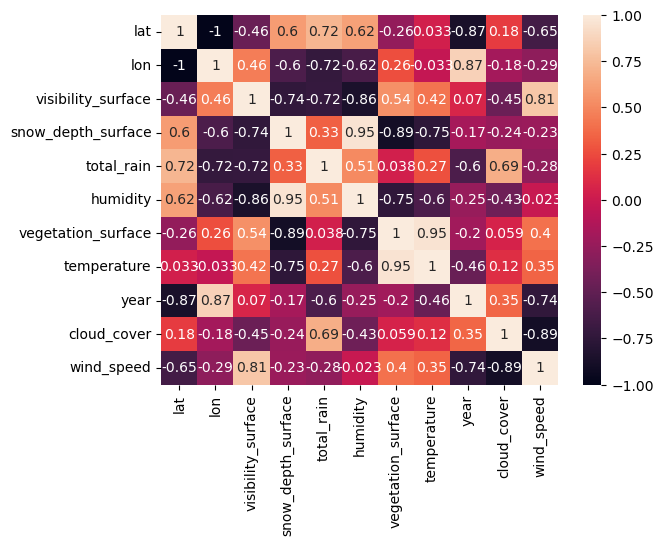

In [161]:
corr_matrix = cd.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

# Weather Station:
### Write a multi-threaded server (outside of Spark) that reads files from the dataset — one file per thread — and then streams them out on a socket for a Spark streaming context to consume (note: not ALL the files have to be opened at once! :-)). The program should produce records as fast as the network will support, i.e., faster than real time. 


In [162]:
# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)

# Travel Startup: 
### After graduating from USF, you found a startup that aims to provide personalized travel itineraries using big data analysis. Given your own personal preferences, build a plan for a year of travel across 5 locations. Or, in other words: pick 5 regions. What is the best time of year to visit them based on the dataset? You have to convince your potential customers that your travel itinerary is better than something they could come up with themselves with a little Googling. You can use pictures, information about local points of interest, etc.

For this problem, I reloaded some of the data from another problem (specifically the 2019 dataset) and split it up into 12 dataframes to represent each month. 

The locations I chose were the following: 
* *dk2* (The Bahamas)
* *9g3* (Mexico City)
* *c20* (Portland)
* *9xc* (Yellowstone) 
* *9q9* (Clear Lake)

We figured out the comfort index for each of the locations as a baseline to figure out when the best time of year to visit them would be. With this information, I filtered the month dataframes by the geohash and the criteria we specified, looking for the month with the most matches and choosing that as our ideal travel time. Most of the ranges fell in the summer months of June to August, but most people go on vacation during the summer anyway, so we didn't decide to change anything.

The descriptions of things to do and places to go are written in the comments above each locations analysis below.

In [163]:
df.createOrReplaceTempView("locations")

lake = spark.sql("SELECT * from locations WHERE (geohash LIKE '9qb%')")

lake.count()

51238

In [164]:
portland = spark.sql("SELECT * from locations WHERE (geohash LIKE 'c20%')")

portland.count()

49368

In [165]:
bahamas = spark.sql("SELECT * from locations WHERE (geohash LIKE 'dk2%')")

bahamas.count()

56474

In [166]:
mexico = spark.sql("SELECT * from locations WHERE (geohash LIKE '9g3%')")

mexico.count()

58718

In [167]:
yellowstone = spark.sql("SELECT * from locations WHERE (geohash LIKE '9xc%')")

yellowstone.count()

50116

In [168]:
yellowstone.take(20)

[Row(time=1554908400000, lat=44.25292921362976, lon=-110.96990375305577, albedo_surface=14.8, precipitable_water_entire_atmosphere_single_layer=5.976626, pressure_maximum_wind=23726.81, pressure_surface=76160.79, pressure_tropopause=26998.84, relative_humidity_zerodegc_isotherm=73.0, snow_depth_surface=0.04912, temperature_surface=274.11514, temperature_tropopause=216.91328, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=0.0625, vegetation_surface=21.0, visibility_surface=24100.0, wilting_point_surface=0.066, wind_speed_gust_surface=29.12514222908, _c18=None, geohash='9xc5dzfpvzfm'),
 Row(time=1554908400000, lat=44.39119211262595, lon=-110.55727792459314, albedo_surface=15.3, precipitable_water_entire_atmosphere_single_layer=5.6766257, pressure_maximum_wind=22240.41, pressure_surface=74589.586, pressure_tropopause=26458.041, relative_humidity_zerodegc_isotherm=78.0, snow_depth_surface=0.04576, temperature_surface=273.30515, tempe

In [169]:
jan = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201901*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

feb = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201902*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

mar = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201903*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

apr = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201904*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

may = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201905*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

jun = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201906*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [172]:
jul = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201907*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

aug = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201908*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

sep = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201909*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

octo = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201910*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

nov = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201911*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

dec = spark.read.load('hdfs://orion01:25001/2019/namanl_218_201912*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [173]:
jan = jan.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jan = jan.withColumn("geohash", geohashEncodeUDF(jan.lat, jan.lon)).withColumn("temperature_surface",\
                                                                               k2f(jan.temperature_surface))
jan = jan.withColumn("wind_speed_gust_surface", jan.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

feb = feb.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
feb = feb.withColumn("geohash", geohashEncodeUDF(feb.lat, feb.lon)).withColumn("temperature_surface",\
                                                                               k2f(feb.temperature_surface))
feb = feb.withColumn("wind_speed_gust_surface", feb.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

mar = mar.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
mar = mar.withColumn("geohash", geohashEncodeUDF(mar.lat, mar.lon)).withColumn("temperature_surface",\
                                                                               k2f(mar.temperature_surface))
mar = mar.withColumn("wind_speed_gust_surface", mar.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

apr = apr.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
apr = apr.withColumn("geohash", geohashEncodeUDF(apr.lat, apr.lon)).withColumn("temperature_surface",\
                                                                               k2f(apr.temperature_surface))
apr = apr.withColumn("wind_speed_gust_surface", apr.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

may = may.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
may = may.withColumn("geohash", geohashEncodeUDF(may.lat, may.lon)).withColumn("temperature_surface",\
                                                                               k2f(may.temperature_surface))
may = may.withColumn("wind_speed_gust_surface", may.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

jun = jun.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jun = jun.withColumn("geohash", geohashEncodeUDF(jun.lat, jun.lon)).withColumn("temperature_surface",\
                                                                               k2f(jun.temperature_surface))
jun = jun.withColumn("wind_speed_gust_surface", jun.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

jul = jul.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jul = jul.withColumn("geohash", geohashEncodeUDF(jul.lat, jul.lon)).withColumn("temperature_surface",\
                                                                               k2f(jul.temperature_surface))
jul = jul.withColumn("wind_speed_gust_surface", jul.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

aug = aug.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
aug = aug.withColumn("geohash", geohashEncodeUDF(aug.lat, aug.lon)).withColumn("temperature_surface",\
                                                                               k2f(aug.temperature_surface))
aug = aug.withColumn("wind_speed_gust_surface", aug.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

sep = sep.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
sep = sep.withColumn("geohash", geohashEncodeUDF(sep.lat, sep.lon)).withColumn("temperature_surface",\
                                                                               k2f(sep.temperature_surface))
sep = sep.withColumn("wind_speed_gust_surface", sep.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

octo = octo.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
octo = octo.withColumn("geohash", geohashEncodeUDF(octo.lat, octo.lon)).withColumn("temperature_surface",\
                                                                               k2f(octo.temperature_surface))
octo = octo.withColumn("wind_speed_gust_surface", octo.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

nov = nov.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
nov = nov.withColumn("geohash", geohashEncodeUDF(nov.lat, nov.lon)).withColumn("temperature_surface",\
                                                                               k2f(nov.temperature_surface))
nov = nov.withColumn("wind_speed_gust_surface", nov.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

dec = dec.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
dec = dec.withColumn("geohash", geohashEncodeUDF(dec.lat, dec.lon)).withColumn("temperature_surface",\
                                                                               k2f(dec.temperature_surface))
dec = dec.withColumn("wind_speed_gust_surface", dec.wind_speed_gust_surface * 2.23694) # convert gust speed to mph
    
jan.take(1)

[Row(time=1546722000000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=1.4045608, pressure_maximum_wind=11128.6875, pressure_surface=101525.72, pressure_tropopause=33332.16, relative_humidity_zerodegc_isotherm=74.0, snow_depth_surface=0.05, temperature_surface=-22.15636599999999, temperature_tropopause=218.16837, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=19.32594917852, _c18=None, geohash='f43k6gf3cc1q')]

In [174]:
jan.createOrReplaceTempView("jan")
feb.createOrReplaceTempView("feb")
mar.createOrReplaceTempView("mar")
apr.createOrReplaceTempView("apr")
may.createOrReplaceTempView("may")
jun.createOrReplaceTempView("jun")
jul.createOrReplaceTempView("jul")
aug.createOrReplaceTempView("aug")
sep.createOrReplaceTempView("sep")
octo.createOrReplaceTempView("oct")
nov.createOrReplaceTempView("nov")
dec.createOrReplaceTempView("dec")

### Clear Lake, California

Ideal Temperature: 65-75 F

Wind Speed: 0-5mph

Cloud Cover: 0-50%

**Ideal Time: Apr-Jul**

Theres a few things a tourist could do when visiting the Clear lake region! 

One thing you can do is go to Clear Lake itself and take a boat out in its crystal clear waters. It's very common for patrons to go bass finshing on the lake and go on a fishing tour! Another thing you could do is hike through the surrounding woods and even do some bird watching while you're at it!

The best thing to do in the summer months is to do some sports on the water, like wakeboarding or jetskiing. Its just warm enough to want to be on the water, but not so hot that you'll get sun burned!

In [175]:
lake = spark.sql("SELECT * from jan WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

212

In [176]:
lake = spark.sql("SELECT * from feb WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

0

In [177]:
lake = spark.sql("SELECT * from mar WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

0

In [178]:
lake = spark.sql("SELECT * from may WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

8

In [179]:
lake = spark.sql("SELECT * from jun WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

778

In [180]:
lake = spark.sql("SELECT * from jul WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

840

In [181]:
lake = spark.sql("SELECT * from aug WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

986

In [182]:
lake = spark.sql("SELECT * from sep WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

328

In [183]:
lake = spark.sql("SELECT * from oct WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

0

In [184]:
lake = spark.sql("SELECT * from nov WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

0

In [185]:
lake = spark.sql("SELECT * from nov WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 40 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 70")

lake.count()

0

In [186]:
lake = spark.sql("SELECT * from dec WHERE (geohash LIKE '9qb%')\
                    AND 65 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 > total_cloud_cover_entire_atmosphere_single_layer")

lake.count()

0

### Bahamas

Ideal Temperature: 75+ F

Wind Speed: 0-5mph

Cloud Cover: 0-10%

**Ideal Time: Jun-Aug**

Who wouldn't want to visit the Carribean in the summer? 

If you go to the bahamas this summer, you can sunbathe on their endless expanses of beaches and cool off in the shallow waters around the islands. Take a boat tour around the islands and marvel in the beautiful blue ocean all around you. If you're feeling even more excited about the ocean, go snorkeling with some friends and explore the reefs together as your surrounded by the native sea animals. Who knows, you might even spot a dolphin or two in those waters!

In [187]:
bahamas = spark.sql("SELECT * from jan WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

36

In [188]:
bahamas = spark.sql("SELECT * from feb WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

16

In [189]:
bahamas = spark.sql("SELECT * from mar WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

22

In [190]:
bahamas = spark.sql("SELECT * from apr WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

43

In [191]:
bahamas = spark.sql("SELECT * from may WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

24

In [192]:
bahamas = spark.sql("SELECT * from jun WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

95

In [193]:
bahamas = spark.sql("SELECT * from jul WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

84

In [194]:
bahamas = spark.sql("SELECT * from aug WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

66

In [195]:
bahamas = spark.sql("SELECT * from sep WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

26

In [196]:
bahamas = spark.sql("SELECT * from oct WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

30

In [197]:
bahamas = spark.sql("SELECT * from nov WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

15

In [198]:
bahamas = spark.sql("SELECT * from dec WHERE (geohash LIKE 'dk2%')\
                    AND 75 < temperature_surface \
                    AND 5 >= wind_speed_gust_surface \
                    AND 0 < total_cloud_cover_entire_atmosphere_single_layer AND total_cloud_cover_entire_atmosphere_single_layer < 10")

bahamas.count()

0

### Yellowstone National Park

Ideal Temperature: 55-75 F

Wind Speed: 0-5mph

Cloud Cover: 50-100%

**Ideal Time: Jul-Aug**

One of the best things to do in Yellowstone is climb one of the many rock faces throughout the park. The best time for this is late summer, when the sun isnt beating down as hard and a small breeze keeps you from sweating too hard while you climb up some of the highest mountains in Wyoming!

In [199]:
yellowstone = spark.sql("SELECT * from jan WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [200]:
yellowstone = spark.sql("SELECT * from feb WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [201]:
yellowstone = spark.sql("SELECT * from mar WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [202]:
yellowstone = spark.sql("SELECT * from apr WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [203]:
yellowstone = spark.sql("SELECT * from may WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

1

In [204]:
yellowstone = spark.sql("SELECT * from jun WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

33

In [205]:
yellowstone = spark.sql("SELECT * from jul WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

115

In [206]:
yellowstone = spark.sql("SELECT * from aug WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

81

In [207]:
yellowstone = spark.sql("SELECT * from sep WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

27

In [208]:
yellowstone = spark.sql("SELECT * from oct WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [209]:
yellowstone = spark.sql("SELECT * from nov WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

In [210]:
yellowstone = spark.sql("SELECT * from dec WHERE (geohash LIKE '9xc%')\
                    AND 55 < temperature_surface AND temperature_surface < 75\
                    AND 5 >= wind_speed_gust_surface \
                    AND 50 < total_cloud_cover_entire_atmosphere_single_layer")

yellowstone.count()

0

### Mexico City, Mexico

Ideal Temperature: 60-85 F

Wind Speed: 0-15mph

Cloud Cover: 50-100%

**Ideal Time: Sept**

Mexico City in September is the perfect place to visit! Theres no shortage of activities for you to do in groups or alone. You could go on a hot air balloon ride over Teotihuacán and get breakfast in one of the cave formations in the mountains! You could also visit the Frida Kahlo museum in the city if you're not up for being hundreds of feet in the air.

In [211]:
mexico = spark.sql("SELECT * from jan WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

1

In [212]:
mexico = spark.sql("SELECT * from feb WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

0

In [213]:
mexico = spark.sql("SELECT * from mar WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

0

In [214]:
mexico = spark.sql("SELECT * from apr WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

16

In [215]:
mexico = spark.sql("SELECT * from may WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

0

In [216]:
mexico = spark.sql("SELECT * from jun WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

10

In [217]:
mexico = spark.sql("SELECT * from jul WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

2

In [218]:
mexico = spark.sql("SELECT * from aug WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

3

In [219]:
mexico = spark.sql("SELECT * from sep WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

62

In [220]:
mexico = spark.sql("SELECT * from oct WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()


14

In [221]:
mexico = spark.sql("SELECT * from nov WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

3

In [222]:
mexico = spark.sql("SELECT * from dec WHERE (geohash LIKE '9g3%')\
                    AND 60 <= temperature_surface AND temperature_surface <= 85\
                    AND 15 <= wind_speed_gust_surface \
                    AND 50 <= total_cloud_cover_entire_atmosphere_single_layer")

mexico.count()

1

### Portland, Oregon

Ideal Temperature: 50-70 F

Wind Speed: 0-10mph

Cloud Cover: 40-100%

**Ideal Time: May-Jun, Sept**

Say hello to California's upstairs neighbor! If you visit Portland, Oregon, theres no lack of places to fisit in its beautiful landscapes. Take a hike in the Columbia River Gorge and visit the waterfall nestled deep in the woods! Go on a wine tasting tour in the Willamette Valley! You could even take a 2.5 hour long cruise down the Willamette River, the possibilities are endless!

In [223]:
portland = spark.sql("SELECT * from jan WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

355

In [224]:
portland = spark.sql("SELECT * from feb WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

0

In [225]:
portland = spark.sql("SELECT * from mar WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

0

In [226]:
portland = spark.sql("SELECT * from apr WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

201

In [227]:
portland = spark.sql("SELECT * from may WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

809

In [228]:
portland = spark.sql("SELECT * from jun WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

718

In [229]:
portland = spark.sql("SELECT * from jul WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

467

In [230]:
portland = spark.sql("SELECT * from aug WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

358

In [231]:
portland = spark.sql("SELECT * from sep WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

942

In [232]:
portland = spark.sql("SELECT * from oct WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

268

In [233]:
portland = spark.sql("SELECT * from nov WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

1

In [234]:
portland = spark.sql("SELECT * from dec WHERE (geohash LIKE 'c20%')\
                    AND 50 <= temperature_surface AND temperature_surface <= 70\
                    AND 10 <= wind_speed_gust_surface \
                    AND 40 <= total_cloud_cover_entire_atmosphere_single_layer")

portland.count()

49